# Import libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.core.debugger import set_trace
import json
from matplotlib import colors

# Load data

In [3]:
PATH = "../data/asocserreprivka-data-psynet/data/"
info = pd.read_csv(PATH + "info.csv", low_memory=False)
networks = pd.read_csv(PATH + "network.csv", low_memory=False)
nodes = pd.read_csv(PATH + "node.csv", low_memory=False)

# Preprocess data

In [4]:
# filter networks
network_data = networks
network_data = network_data[network_data["role"] == "experiment"]
network_data = network_data[network_data["failed"] == 'f']
network_data = network_data[network_data["trial_maker_id"] == 'graph_experiment']

experiment_net_id = list(network_data['id'].to_numpy())

# filter info
info_data = info
info_data = info_data[info["type"] == "graph_chain_trial"]
info_data = info_data[info_data["failed"] == "f"]
info_data = info_data[info_data["network_id"].isin(experiment_net_id)]
info_data = info_data[["id", "network_id", "origin_id", "answer", "definition"]]

# filter nodes
node_data = nodes
node_data = node_data[nodes["type"] == "graph_chain_node"]
node_data = node_data[node_data["failed"] == "f"]
node_data = node_data[node_data["network_id"].isin(experiment_net_id)]
node_data = node_data[["id", "network_id", "degree", "definition", "seed", "vertex_id", "dependent_vertex_ids"]]

# Error analysis

In [5]:
# Extracts the answer necklace
# answer (a) is given as a string formatted as "[i, [x, x, x, x, x, x, x, x, x]" where i is the choice of necklace in 'choice' round and the list is the necklace reproduced
# if the person tried to submit an invalid necklace first (containing '-1') there will be two lists
def extract_answer_necklace(a):
    a = a.strip('][').split(', ', 1)    # strip the outer brackets and split into choice/reproduce
    if '-1' in a[1]:                    # remove the invalid reproduced necklace if relevant
        a[1] = a[1].strip('[').split('], [')[1]
    a[1] = a[1].strip('][').split(', ') # remove the outer brackets of the necklace and split 
    a[1] = [int(x) for x in a[1]]       # turn circles into ints
    return a[1]

In [6]:
# Adds choice, parsed_definition, and reproduced_necklace columns
def extract_choice(a):
    a = a.strip('][').split(', ', 1)
    a = int(a[0])
    return a

def convert_json(d):
    return json.loads(d)

info_data["choice"] = info_data["answer"].apply(extract_choice)
info_data["parsed_definition"] = info_data["definition"].apply(convert_json)
info_data["reproduced_necklace"] = info_data["answer"].apply(extract_answer_necklace)

In [7]:
# Adds chosen_necklace column using above information
chosen_necklaces = []
for i in range(len(info_data)):
    curr_row = info_data.iloc[i]
    curr_necklace = curr_row["parsed_definition"][curr_row["choice"]]["content"]
    chosen_necklaces.append(curr_necklace)
info_data["chosen_necklace"] = chosen_necklaces
# info_data["chosen_necklace"] = info_data.apply(lambda x: extract_chosen_necklace( info_data.parsed_definition, info_data.choice), axis=1)

In [8]:
# Returns the number of positions in which the definition_necklace and answer_necklace differ
def error_score(definition_necklace, answer_necklace):
    if len(answer_necklace) != len(definition_necklace):
        return None

    score = 0
    for i, def_circle in enumerate(definition_necklace):
        if (answer_necklace[i] != def_circle):
            score += 1
    return score

error_scores = []

for i in range(len(info_data)):
    curr_row = info_data.iloc[i]
    err = error_score(curr_row["chosen_necklace"], curr_row["reproduced_necklace"])
    error_scores.append(err)
info_data["error_score"] = error_scores
info_data = info_data[info_data["error_score"] != None]

In [9]:
degrees = []
for i in range(len(info_data)):
    curr_row = info_data.iloc[i]
    node_id = curr_row["origin_id"]
    node_row = node_data[node_data["id"] == node_id]
    degrees.append(node_row.iloc[0]["degree"])
info_data["degree"] = degrees
info_data = info_data.sort_values("degree")

In [10]:
mean_errors = []
for i in range(1, 22):
    j = float(i)
    nodes_of_degree = info_data[info_data["degree"] == j]
    error_in_degree = nodes_of_degree["error_score"]
    mean_errors.append(error_in_degree.mean())

In [11]:
mean_errors = pd.Series(mean_errors)

In [12]:
mean_errors.to_csv("asocial-mean-errors-by-degree.csv")

<AxesSubplot:title={'center':'average number of errors in each iteration, asocial condition'}, xlabel='iteration', ylabel='average number of errors'>

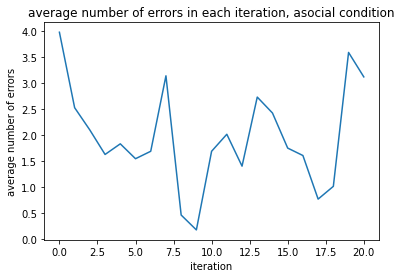

In [13]:
mean_errors.plot.line(xlabel="iteration", ylabel="average number of errors", title="average number of errors in each iteration, asocial condition")

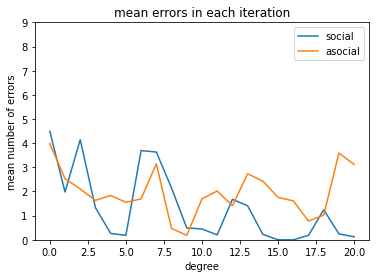

In [17]:
social_mean_errors = pd.read_csv("social-mean-errors-by-degree.csv")
asocial_mean_errors = pd.read_csv("asocial-mean-errors-by-degree.csv")

ax = social_mean_errors["0"].plot(xlabel="degree", ylabel="mean number of errors", title="mean errors in each iteration", label="social", ylim=(0, 9))
asocial_mean_errors["0"].plot(ax=ax, label="asocial")
ax.legend()